# Function 8

## Function Description
You’re optimising an eight-dimensional black-box function, where each of the eight input parameters affects the output, but the internal mechanics are unknown.

Your objective is to find the parameter combination that maximises the function’s output, such as performance, efficiency or validation accuracy. Because the function is high-dimensional and likely complex, global optimisation is hard, so identifying strong local maxima is often a practical strategy.

For example, imagine you’re tuning an ML model with eight hyperparameters: learning rate, batch size, number of layers, dropout rate, regularisation strength, activation function (numerically encoded), optimiser type (encoded) and initial weight range. Each input set returns a single validation accuracy score between 0 and 1. Your goal is to maximise this score.

## Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

## Data

In [2]:
# Initialize the dataset (Function 8)
df_init = pd.DataFrame({
    "x1": [0.604994453,0.178006959,0.009076977,0.506028164,0.359909264,0.778818344,0.908649322,0.586371444,0.761137326,0.984933202,
           0.112071314,0.791887508,0.143550296,0.769916548,0.056447411,0.862437445,0.351511904,0.735903638,0.680293974,0.044329253,
           0.77834548,0.898887111,0.145120286,0.338954419,0.176150018,0.02894663,0.192639868,0.943185017,0.532721401,0.447095841,
           0.382224965,0.53281953,0.394865187,0.98594539,0.964573386,0.472070709,0.856006953,0.810031736,0.796252524,0.481245331],
    "x2": [0.29221502,0.566222654,0.811626153,0.653730123,0.249075679,0.003419499,0.0622497,0.880735726,0.85467239,0.699506258,
           0.437735663,0.576191336,0.937414515,0.458759088,0.065955553,0.482733822,0.590064942,0.034611889,0.255104646,0.013581487,
           0.751145652,0.523641705,0.11932754,0.566932018,0.293961428,0.028279058,0.630677279,0.218850618,0.833692597,0.843952527,
           0.557135837,0.862308484,0.331801666,0.873053629,0.973979787,0.168202645,0.638893704,0.635046041,0.007036533,0.102460721],
    "x3": [0.908452748,0.994861845,0.52052036,0.363410779,0.49599717,0.33798313,0.238259546,0.745020752,0.382124331,0.998885497,
           0.596598785,0.694528359,0.232324818,0.559000445,0.022928678,0.281869398,0.909436304,0.728030269,0.862187985,0.25819824,
           0.314142208,0.876783255,0.420888224,0.376751098,0.975679966,0.481371555,0.416795837,0.721184081,0.071399004,0.729546115,
           0.853101634,0.538267119,0.740754301,0.070392619,0.663753351,0.086427566,0.326192022,0.269547579,0.35569738,0.219485939],
    "x4": [0.355506242,0.210325006,0.075686675,0.177981049,0.709214981,0.519527778,0.766603545,0.546034849,0.337351983,0.180148456,
           0.592775633,0.283423782,0.009043485,0.694604441,0.038786472,0.544102227,0.678408354,0.147426522,0.134395821,0.577644163,
           0.902985775,0.218696449,0.387608607,0.098915729,0.793936306,0.6131746,0.490529289,0.424597072,0.116811483,0.639151378,
           0.333795692,0.049442935,0.697861725,0.053587293,0.662215992,0.452655513,0.668503115,0.869605338,0.487566053,0.677322369],
    "x5": [0.201668719,0.320152657,0.265111825,0.093728304,0.114987195,0.820906993,0.132335962,0.009648878,0.68970832,0.580143147,
           0.22698177,0.136755461,0.41457893,0.503199022,0.403935441,0.88749026,0.212825656,0.295743139,0.3263292,0.051279923,
           0.335381656,0.900260894,0.155422833,0.659451687,0.923400762,0.672660448,0.796086023,0.986902,0.73069311,0.409287137,
           0.265721272,0.719701189,0.737404439,0.734152958,0.673121672,0.48061922,0.240298369,0.66192159,0.740519615,0.247509187],
    "x6": [0.575338005,0.707908792,0.091651689,0.197425331,0.289206921,0.537246689,0.990243814,0.748991763,0.309853052,0.231087191,
           0.410104519,0.279161861,0.409325169,0.728346383,0.801055329,0.382654693,0.08846038,0.445117308,0.287906871,0.158563071,
           0.386322669,0.282766245,0.875171626,0.24554809,0.030842294,0.022113407,0.654567065,0.535182984,0.937375591,0.132645694,
           0.480872916,0.906705899,0.78377681,0.520258522,0.905237624,0.622439489,0.21029889,0.252258727,0.706650103,0.244340858],
    "x7": [0.310310951,0.635384489,0.592415145,0.7558269,0.557295151,0.551347098,0.688067822,0.23090707,0.631379683,0.490826936,
           0.921237577,0.842767264,0.553778522,0.784253534,0.488307007,0.601901993,0.410152995,0.975179686,0.435010484,0.591030124,
           0.748972486,0.91107791,0.510559672,0.762482784,0.803254524,0.601483302,0.276241193,0.714743177,0.866507981,0.035908876,
           0.237647062,0.108230943,0.254495461,0.811040045,0.458874624,0.928974462,0.167546362,0.765670033,0.992914495,0.163824527],
    "x8": [0.734281377,0.107131627,0.367320262,0.292472339,0.593881726,0.660032086,0.742495941,0.097915623,0.041956069,0.31368272,
           0.674752759,0.625327922,0.2058408,0.663131087,0.893084977,0.47646169,0.195724292,0.374339784,0.364200126,0.077952934,
           0.988755104,0.472398218,0.728610579,0.732153467,0.595897583,0.524885053,0.295517586,0.96009372,0.127901999,0.44683847,
           0.768631956,0.525347913,0.87114551,0.103360365,0.560917502,0.112536267,0.963589863,0.890548667,0.381734367,0.71596164],
    "y":  [7.398721101,7.005227362,8.459481616,8.284007811,8.606116791,8.541747924,7.327434576,7.299872047,7.957874742,5.59219339,
           7.854540991,6.791985783,8.976554022,7.379082904,9.598482003,8.159983192,7.131623966,6.767962535,7.433744072,9.013075146,
           7.310893815,5.841067313,9.141639493,8.817558441,6.451943125,8.830745046,9.344274281,6.887846394,8.042212542,7.692368046,
           7.923758772,8.421759238,8.2780624,7.113457164,6.402588415,8.472936317,7.977684585,7.460872195,7.436593527,9.183005245]
})
new_data = [
    (0.099896, 0.203055, 0.13721, 0.075792, 0.797066, 0.221595, 0.142286, 0.169012, 9.8887718403696),  # week 1
    (0.214866, 0.734996, 0.004271, 0.196426, 0.568329, 0.165606, 0.043865, 0.986021, 9.3794999952224),  # week 2
    (0.007673, 0.568726, 0.040898, 0.660850, 0.778819, 0.979967, 0.067300, 0.103288, 9.2323512657901),  # week 3
    (0.168448, 0.000956, 0.329626, 0.067375, 0.828721, 0.407942, 0.050532, 0.709258, 9.7872748980141),  # week 4
    (0.090910, 0.196692, 0.060807, 0.009524, 0.946161, 0.593729, 0.055367, 0.844509, 9.8962755617254),  # week 5
    (0.222335, 0.308553, 0.049727, 0.116281, 0.958121, 0.079513, 0.033395, 0.056822, 9.6501318786851),  # week 6
    (0.004881, 0.192218, 0.218921, 0.052497, 0.499610, 0.000138, 0.451280, 0.142259, 9.5046796702199),  # week 7
    (0.027923, 0.289458, 0.119566, 0.038317, 0.006969, 0.362504, 0.017747, 0.709288, 9.5563806486121),  # week 8
    (0.066805, 0.008126, 0.122484, 0.103251, 0.891880, 0.243924, 0.978068, 0.989416, 8.6795730199754),  # week 9
    (0.167527, 0.235307, 0.026702, 0.268646, 0.435844, 0.612132, 0.255562, 0.358441, 9.8466268922369),  # week 10
    (0.046586, 0.198720, 0.137921, 0.062705, 0.817391, 0.452737, 0.355193, 0.486599, 9.9322708792724),  # week 11
    (0.044569, 0.380059, 0.116576, 0.029669, 0.548132, 0.712850, 0.091807, 0.817238, 9.8207529515336),  # week 12
    (0.107549, 0.146351, 0.080146, 0.059077, 0.817180, 0.418220, 0.228001, 0.746429, 9.9736016523139),  # week 13
]
df_new = pd.DataFrame(new_data, columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "y"])
df_all = pd.concat([df_init, df_new], ignore_index=True)
# Extract input (X) and output (y)  ---- (updated to 8 features)
X = df_all[["x1","x2","x3","x4","x5","x6","x7","x8"]].values  # shape (n, 8)
y = df_all["y"].values.reshape(-1, 1)  # shape (n, 1)

## Optimisation Model
### Regression Neural Network

[Regression] Epoch    1 | Train MSE(norm): 1.1131 | Val MSE(norm): 0.7565 | Val RMSE(orig y): 0.9972
[Regression] Epoch  100 | Train MSE(norm): 0.0151 | Val MSE(norm): 0.0410 | Val RMSE(orig y): 0.2321
[Regression] Epoch  200 | Train MSE(norm): 0.0034 | Val MSE(norm): 0.0308 | Val RMSE(orig y): 0.2011
[Regression] Epoch  300 | Train MSE(norm): 0.0007 | Val MSE(norm): 0.0307 | Val RMSE(orig y): 0.2009
[Regression] Epoch  400 | Train MSE(norm): 0.0005 | Val MSE(norm): 0.0330 | Val RMSE(orig y): 0.2084
[Regression] Epoch  500 | Train MSE(norm): 0.0001 | Val MSE(norm): 0.0310 | Val RMSE(orig y): 0.2018
[Regression] Epoch  600 | Train MSE(norm): 0.0001 | Val MSE(norm): 0.0304 | Val RMSE(orig y): 0.1998
[Regression] Epoch  700 | Train MSE(norm): 0.0003 | Val MSE(norm): 0.0315 | Val RMSE(orig y): 0.2036
[Regression] Epoch  800 | Train MSE(norm): 0.0000 | Val MSE(norm): 0.0308 | Val RMSE(orig y): 0.2013
[Regression] Epoch  900 | Train MSE(norm): 0.0003 | Val MSE(norm): 0.0309 | Val RMSE(orig y

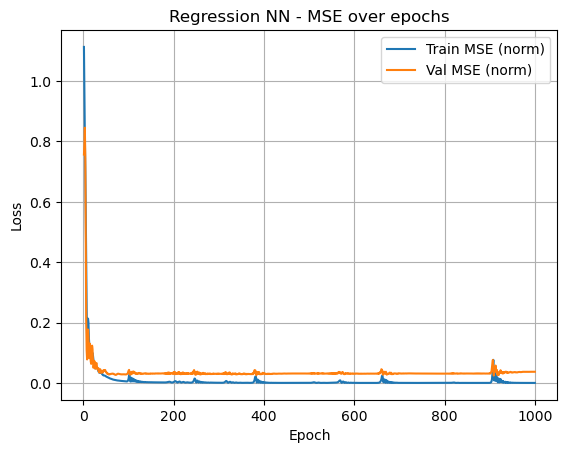

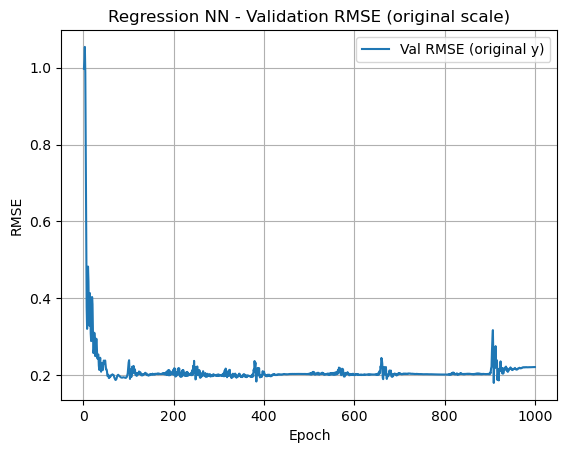


[Regression NN] Suggested next point (just for reference):
x: [0.01115214 0.3615993  0.01143984 0.22199148 0.5291357  0.26189652
 0.0056173  0.94905967]
Predicted y: 9.9450



In [3]:
# ================================
# Simple PyTorch NN for Function 8
# ================================

# ----------------
# Hyperparameters
# ----------------
input_dim = 8           # x1..x8
hidden_dim = 32         # size of hidden layers
num_hidden_layers = 2   # number of hidden layers
learning_rate = 0.02
weight_decay = 1e-4     # L2 regularisation (0 = off)
test_size = 0.2         # validation split
random_state = 42

num_epochs_reg = 1000    # epochs for regression NN
num_epochs_clf = 1000    # epochs for classification NN

n_candidates = 5000     # random candidate points in [0,1]^8
good_quantile = 0.75    # top 25% of y are "good" for classifier

# -------------------------
# Model definitions
# -------------------------
class SimpleNet(nn.Module):
    """Regression network: x -> y"""
    def __init__(self, input_dim, hidden_dim, num_hidden_layers, output_dim=1):
        super(SimpleNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class SimpleClassifier(nn.Module):
    """Classification network: x -> logit(good)"""
    def __init__(self, input_dim, hidden_dim, num_hidden_layers):
        super(SimpleClassifier, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 1))  # logit output
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


torch.manual_seed(random_state)

# ==================================================
# 1) Regression NN: x -> y  (for surrogate modelling)
# ==================================================

# Normalise y for easier training
y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

X_train, X_val, y_train, y_val = train_test_split(
    X, y_norm, test_size=test_size, random_state=random_state
)

X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_val_t = torch.from_numpy(X_val).float()
y_val_t = torch.from_numpy(y_val).float()

reg_model = SimpleNet(input_dim, hidden_dim, num_hidden_layers, output_dim=1)
reg_criterion = nn.MSELoss()
reg_optimizer = optim.Adam(reg_model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

reg_train_loss = []
reg_val_loss = []
reg_val_rmse = []

for epoch in range(1, num_epochs_reg + 1):
    # ---- Train step ----
    reg_model.train()
    reg_optimizer.zero_grad()
    y_pred_train = reg_model(X_train_t)
    loss_train = reg_criterion(y_pred_train, y_train_t)
    loss_train.backward()
    reg_optimizer.step()

    # ---- Validation step ----
    reg_model.eval()
    with torch.no_grad():
        y_pred_val = reg_model(X_val_t)
        loss_val = reg_criterion(y_pred_val, y_val_t).item()

        # Convert validation predictions back to original y scale for RMSE
        y_pred_val_orig = y_pred_val.numpy() * y_std + y_mean
        y_val_orig = y_val_t.numpy() * y_std + y_mean
        rmse_val_orig = np.sqrt(((y_pred_val_orig - y_val_orig) ** 2).mean())

    reg_train_loss.append(loss_train.item())
    reg_val_loss.append(loss_val)
    reg_val_rmse.append(rmse_val_orig)

    if epoch % 100 == 0 or epoch == 1:
        print(f"[Regression] Epoch {epoch:4d} "
              f"| Train MSE(norm): {loss_train.item():.4f} "
              f"| Val MSE(norm): {loss_val:.4f} "
              f"| Val RMSE(orig y): {rmse_val_orig:.4f}")

# ---- Plot regression training curves ----
epochs_reg = np.arange(1, num_epochs_reg + 1)

plt.figure()
plt.plot(epochs_reg, reg_train_loss, label="Train MSE (norm)")
plt.plot(epochs_reg, reg_val_loss, label="Val MSE (norm)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Regression NN - MSE over epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs_reg, reg_val_rmse, label="Val RMSE (original y)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Regression NN - Validation RMSE (original scale)")
plt.legend()
plt.grid(True)
plt.show()

# Optionally: use regression NN to suggest a point (just for reference)
reg_model.eval()
with torch.no_grad():
    X_cand = np.random.rand(n_candidates, input_dim).astype(np.float32)
    X_cand_t = torch.from_numpy(X_cand)
    y_cand_norm = reg_model(X_cand_t).numpy()
    y_cand = y_cand_norm * y_std + y_mean

best_idx_reg = np.argmax(y_cand)
best_x_reg = X_cand[best_idx_reg]
best_y_pred_reg = y_cand[best_idx_reg, 0]

print("\n[Regression NN] Suggested next point (just for reference):")
print("x:", best_x_reg)
print(f"Predicted y: {best_y_pred_reg:.4f}")
print("")

### Neural Network Ensemble

In [4]:
# -------------------------
# Ensemble hyperparameters
# -------------------------
ensemble_seeds = [0, 1, 2, 3, 4]   # size of ensemble
beta = 0.5                        # uncertainty weight (like UCB)

# -------------------------
# Generate candidates once
# -------------------------
X_cand = np.random.rand(n_candidates, input_dim).astype(np.float32)
X_cand_t = torch.from_numpy(X_cand).float()

all_preds = []

# -------------------------
# Train ensemble members
# -------------------------
for seed in ensemble_seeds:
    torch.manual_seed(seed)

    model = SimpleNet(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_hidden_layers=num_hidden_layers,
        output_dim=1
    )

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    criterion = torch.nn.MSELoss()

    # ---- Train ----
    for epoch in range(num_epochs_reg):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = criterion(y_pred, y_train_t)
        loss.backward()
        optimizer.step()

    # ---- Predict candidates ----
    model.eval()
    with torch.no_grad():
        y_cand_norm = model(X_cand_t).numpy()
        y_cand = y_cand_norm * y_std + y_mean
        all_preds.append(y_cand.reshape(-1))

# -------------------------
# Ensemble aggregation
# -------------------------
all_preds = np.vstack(all_preds)     # shape: (n_models, n_candidates)

mean_pred = all_preds.mean(axis=0)
std_pred  = all_preds.std(axis=0)

# UCB-style score
score = mean_pred + beta * std_pred

# -------------------------
# Optional: diversity filter
# -------------------------
top_k = 50
top_idx = np.argsort(score)[-top_k:]

# distance from existing samples (encourage exploration)
dmin = cdist(X_cand[top_idx], X).min(axis=1)
best_idx = top_idx[np.argmax(dmin)]

# -------------------------
# Final recommendation
# -------------------------
x_next = X_cand[best_idx]
y_mean_pred = mean_pred[best_idx]
y_uncertainty = std_pred[best_idx]

print("[NN Ensemble] Next suggested x:")
print(x_next)
print(f"Ensemble mean prediction: {y_mean_pred:.4f}")
print(f"Ensemble uncertainty (std): {y_uncertainty:.4f}")

[NN Ensemble] Next suggested x:
[0.03331793 0.6041444  0.19770241 0.59529054 0.44429326 0.32223138
 0.02323515 0.56268656]
Ensemble mean prediction: 9.6202
Ensemble uncertainty (std): 0.1760
